In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import os
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from scipy.stats import f_oneway
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_validate
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import PCA
from gensim.models import Word2Vec
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize  # You may need to install nltk and download punkt
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from scipy.stats import ttest_rel
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_fscore_support
from utilities import *

import torch
from transformers import BertModel
from torch.utils.data import Dataset, DataLoader
from transformers import BertModel, BertTokenizer
from transformers import BertTokenizer, BertForSequenceClassification, AdamW

[nltk_data] Downloading package punkt to /Users/valerio/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
# Upload the DataFrame
df = pd.read_csv('data/modelready_220423.csv')

## Cleaning dataset

In [3]:
# Print non-numerical columns
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
print(f'tot columns = {len(df.columns)}, numeric type columns = {len(df.select_dtypes(include=numerics).columns)}' ) # not too many non-numeric columns
df.select_dtypes(include = ['object']).head(1)  

tot columns = 772, numeric type columns = 765


,publication_number,company_name,countries_in_family,publn_nr,primary_cpc,abstract,description_text
0,US-8623043-B1,"Entellus Medical, Inc.",['AU' 'EP' 'CA' 'US'],8623043,A61M29/02,A method of treating a constricted sinus passa...,RELATED APPLICATIONS \n This Application i...


In [4]:
# Extract unique countries in the df
unique_values = set()
df['countries_in_family'].apply(lambda x: unique_values.update(x.strip("[]").replace("'", "").split())) 

# Create new columns for each unique value (one-hot encoding)
for value in unique_values:
    # each country has a column (1 if the patent belong to the country 0 otherwise)
    df[value] = df['countries_in_family'].apply(lambda x: 1 if value in x else 0)


In [5]:
df = df[df.abstract.notna()].copy() # drop all samples without abstract (no way to impute it)
print('missing value in description text' , df.description_text.isna().sum()) # description_text doesn't have mssing vales

missing value in description text 0


In [6]:
# Encode company names
df['company_name_encoded'] = df.company_name.astype('category').cat.codes  # encode companies

# Remove non-numeric columns
df_columns_dropped = df.drop(['publication_number', 'company_name', 'countries_in_family', 'publn_nr','primary_cpc'], axis = 1)

# f0_ has the same value as commercialization, the other two shouldn't be used
df_columns_dropped = df_columns_dropped.drop(['f0_', 'centrality', 'similarity'], axis = 1)

In [7]:
# Remove text as we can't compute min and max on it
text = df_columns_dropped[['abstract', 'description_text']] # putting them aside for later
df_columns_dropped.drop(['abstract', 'description_text'], axis=1, inplace=True)

In [8]:
# Extracting what we'll try to predict
y = df_columns_dropped['commercialized']
df_columns_dropped.drop('commercialized', axis= 1, inplace=True)

In [9]:
# Dropping columns where all the value are the same (only one unique value) they would be zero if I apply min max rescaling
nunique = df_columns_dropped.nunique()
cols_to_drop = nunique[nunique == 1].index
df_clean = df_columns_dropped.drop(cols_to_drop, axis=1)

In [10]:
for feature_name  in df_clean.columns: 
    feature_name.replace('v1', 'ge')

In [11]:
# renaming google embedings for clarity
df_clean.columns = [s.replace('v1', 'ge') for s in df_clean.columns]

In [12]:
# Splitting train and test and trying best preprocessing on training set
# All preprocessing will be done on X_train and only in the end tested on X_test
X_train, X_test, y_train, y_test = train_test_split(df_clean, y, test_size=0.20)

### Select best way to fill missin values

In [13]:
# expected time to run: 3 minutes

accuracies = []

#rescale 
scaler = ('scaler', StandardScaler())
filling_methods = ['mean', 'median', 'most_frequent', 'zero']

for method in filling_methods:
    # Make a copy of the original data to avoid modifying it
    data_filled = X_train.copy()

    # Fill NaN values based on the selected method
    if method == 'zero':
        # data_filled = data_filled.fillna(0)  # You can choose any constant value
        imputer =  ('imputer', SimpleImputer(strategy='constant', fill_value=0))
    else:
        imputer = ('imputer', SimpleImputer(strategy=method, keep_empty_features=False))
    
    # Default max_iter was reached, so increased it
    model = ('model', LogisticRegression(max_iter=1000))

    pipeline = Pipeline([imputer ,scaler, model])

    # Perform cross-validation and print the mean score
    scores_dict = cross_validate(estimator=pipeline, X=data_filled, y=y_train, n_jobs=5, cv=5,scoring=['f1', 'accuracy', 'precision', 'recall'])

    accuracies.append(scores_dict["test_accuracy"])

    # Print the results
    print(f'method:{method}')
    print(f'Average F1 Score: {np.mean(scores_dict["test_f1"])}')
    print(f'Average Accuracy: {np.mean(scores_dict["test_accuracy"])}')
    print(f'Average Precision: {np.mean(scores_dict["test_precision"])}')
    print(f'Average Recall: {np.mean(scores_dict["test_recall"])}')
    print() 

method:mean
Average F1 Score: 0.8757077252216657
Average Accuracy: 0.8922643745207782
Average Precision: 0.8886133260364527
Average Recall: 0.8631878236910417

method:median
Average F1 Score: 0.8758913138080681
Average Accuracy: 0.8924275283730971
Average Precision: 0.8888289418314926
Average Recall: 0.8633467498937726

method:most_frequent
Average F1 Score: 0.8759989506682043
Average Accuracy: 0.8925673993801008
Average Precision: 0.8893386178694819
Average Recall: 0.8630815260627441

method:zero
Average F1 Score: 0.8760295174310129
Average Accuracy: 0.8925907175559855
Average Precision: 0.8893443637162098
Average Recall: 0.863134576453163



In [14]:
# Perform ANOVA test to see if there is significant difference between the accuracies

f_statistic, p_value = f_oneway(*accuracies)

# Print the results
print(f'F-statistic: {f_statistic}')
print(f'P-value: {p_value}')

# Check if the p-value is below the significance level (e.g., 0.05)
if p_value < 0.05:
    print('The means of the accuracy vectors are significantly different.')
else:
    print('There is no significant difference in means between the accuracy vectors.')

F-statistic: 0.01288102659911202
P-value: 0.9979154702110262
There is no significant difference in means between the accuracy vectors.


In [15]:
# Create new train test split with missing values filled (now that we know best method to fill)
df_clean.fillna(0, inplace=True) 
X_train, X_test, y_train, y_test = train_test_split(df_clean, y, test_size=0.20)

So, it doesn't matter which filling method we will use. 

### Vectorization of text (bag of words)

In [16]:
# Putting text back in the DataFrame df_clean
df_clean_text = df_clean.copy()
df_clean_text[['abstract', 'description_text']] = text  

# Split again
X_train, X_test, y_train, y_test = train_test_split(df_clean_text, y, test_size=0.20, random_state=42)

X_no_text = X_train.drop(['abstract', 'description_text'],  axis = 1)

In [20]:
# Expected runtime: 30s 

# Tokenize the text
tokenized_text = [word_tokenize(text) for text in X_train['abstract']]

# Train Word2Vec model
word2vec_model = Word2Vec(sentences=tokenized_text, vector_size=300, window=5, min_count=1, workers=8)

# Encode abstracts using the trained Word2Vec model
encoded_abstracts = []
for words in tokenized_text:
    # Take the mean of word vectors for each abstract
    encoded_abstract = np.mean([word2vec_model.wv[word] for word in words if word in word2vec_model.wv] or [np.zeros(100)], axis=0)
    encoded_abstracts.append(encoded_abstract)


In [21]:
# Expected runtime: 3 minutes

# Create pipeline, logist regression is used as it is our baseline model
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),  # Fill missing values with zero
    ('scaler', StandardScaler(with_mean=False)), 
    ('random_forest', LogisticRegression(random_state=42, max_iter=10000))
    ])

# Define vectorizers
vectorizers = {
    'Count Vectorizer': CountVectorizer(max_features = 300),
    'Word2Vec' : None,
    'TF-IDF Vectorizer': TfidfVectorizer(max_features = 300),
}

X_train_only_text = X_train[['abstract']]

# Tokenize text for Word2Vec
tokenized_text = [word_tokenize(text) for text in X_train['abstract']]

# Train Word2Vec model
word2vec_model = Word2Vec(sentences=tokenized_text, vector_size=100, window=5, min_count=1, workers=4)
accuracies = []

# Transform text data using different vectorization methods and evaluate models
for vectorizer_name, vectorizer in vectorizers.items():
    if 'Word2Vec' in vectorizer_name:
        # Use Word Embeddings (Word2Vec) for Word Embeddings model
        X_train_transformed = np.array([np.mean([word2vec_model.wv[word] for word in words if word in word2vec_model.wv] or [np.zeros(100)], axis=0) for words in tokenized_text])
        X_train_transformed = pd.DataFrame(X_train_transformed).reset_index(drop=True)
    else:
        # Use Count Vectorization or TF-IDF Vectorization for other models
        X_train_transformed = vectorizer.fit_transform(X_train_only_text['abstract'].values)
        X_train_transformed = pd.DataFrame(X_train_transformed.toarray()).reset_index(drop=True)

    
    X_train_transformed = pd.concat([X_no_text.reset_index(drop=True), X_train_transformed], axis=1)
    X_train_transformed.columns = X_train_transformed.columns.astype(str) 

    # Evaluate the model using cross-validation
    scores_dict = cross_validate(pipeline, X_train_transformed, y_train, cv=2, n_jobs=5, scoring=['f1', 'accuracy', 'precision', 'recall'])

    # Print the mean accuracy for each combination
    accuracies.append(scores_dict["test_accuracy"])

    # Print the results
    print(f'model:{vectorizer_name}')
    print(f'Average F1 Score: {np.mean(scores_dict["test_f1"])}')
    print(f'Average Accuracy: {np.mean(scores_dict["test_accuracy"])}')
    print(f'Average Precision: {np.mean(scores_dict["test_precision"])}')
    print(f'Average Recall: {np.mean(scores_dict["test_recall"])}')
    print() 


model:Count Vectorizer
Average F1 Score: 0.87398370515502
Average Accuracy: 0.8907022288538655
Average Precision: 0.8869043934111215
Average Recall: 0.8614349300551081

model:Word2Vec
Average F1 Score: 0.8737803111240663
Average Accuracy: 0.8905390282570176
Average Precision: 0.8868216611039244
Average Recall: 0.8611169987282747

model:TF-IDF Vectorizer
Average F1 Score: 0.8734059120159636
Average Accuracy: 0.8901193695794087
Average Precision: 0.885658668031578
Average Recall: 0.8614879186095803



In this section we have considered a dataset made of the features and the words embedings (created with different techniques). CountVectorizer is the one that leads to the best results, but these (even if close) don't improve the baseline model. Thus in the following section we won't consider the word embeddings. <br>
Due to computational limitation we could only compute the word embeding on the abstract (as it was shorter) and not on description_text (text description of images). In any case the abstract is probably the one with more relevant information. 

In [22]:
del X_train_transformed, encoded_abstract, word2vec_model, X_train_only_text
del X_train, X_test, y_train, y_test, df_clean_text

### Model selection

IMPORTANT: while testing on PC with low RAM availability we found out that the python Kernel crushed because it didn't have enough memory. If that's the case for the following cells restart the notebook and only run "Cleaning and baseline models" section, then start from here. 

In [13]:
# Create new train test split with missing values filled (now that we know best method to fill)
df_clean.fillna(0, inplace=True) 
X_train, X_test, y_train, y_test = train_test_split(df_clean, y, test_size=0.20)

In [14]:
# Expected execution time: 22 minutes

# Model selection
accuracies = []

pipe_step = [('imputer', SimpleImputer(strategy='constant', fill_value=0)),  # Fill missing values with zero
    ('scaler', MinMaxScaler())]

models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Neural Network': MLPClassifier(random_state=42, max_iter=1000),
    'Gradient Boosted Trees': GradientBoostingClassifier(random_state=42),
    'SVM': SVC(random_state=42)
}

# Perform model selection using cross-validation
for model_name, model in models.items():
    

    pipeline = Pipeline(pipe_step + [(model_name, model)])
    # Print the cross-validation scores
    scores_dict = cross_validate(estimator=pipeline, X=X_train, y=y_train, cv=5, n_jobs=5, scoring=['f1', 'accuracy', 'precision', 'recall'])

    accuracies.append(scores_dict["test_accuracy"])

    # Print the results
    print(f'model:{model_name}')
    print(f'Average F1 Score: {np.mean(scores_dict["test_f1"])}')
    print(f'Average Accuracy: {np.mean(scores_dict["test_accuracy"])}')
    print(f'Average Precision: {np.mean(scores_dict["test_precision"])}')
    print(f'Average Recall: {np.mean(scores_dict["test_recall"])}')
    print() 


model:Random Forest
Average F1 Score: 0.9102131674025129
Average Accuracy: 0.9215237797425984
Average Precision: 0.9158357069219314
Average Recall: 0.9046659597030754

model:Logistic Regression
Average F1 Score: 0.8770147946941019
Average Accuracy: 0.8937562485849089
Average Precision: 0.8929966775249427
Average Recall: 0.861611876988335

model:Neural Network
Average F1 Score: 0.8934101015357596
Average Accuracy: 0.9052969247647209
Average Precision: 0.8846392235804516
Average Recall: 0.902492046659597

model:Gradient Boosted Trees
Average F1 Score: 0.8836374543626777
Average Accuracy: 0.8999113637542763
Average Precision: 0.9038458762535324
Average Recall: 0.8643160127253446

model:SVM
Average F1 Score: 0.8808017062401664
Average Accuracy: 0.8979295661180491
Average Precision: 0.9050530928948817
Average Recall: 0.857847295864263



In [ ]:
# Perform ANOVA test to see if there is significant difference between the accuracies
f_statistic, p_value = f_oneway(*accuracies)

# Print the results
print(f'F-statistic: {f_statistic}')
print(f'P-value: {p_value}')

# Check if the p-value is below the significance level (e.g., 0.05)
if p_value < 0.05:
    print('The means of the accuracy vectors are significantly different.')
else:
    print('There is no significant difference in means between the accuracy vectors.')

F-statistic: 48.74186502883015
P-value: 4.893122317602524e-10
The means of the accuracy vectors are significantly different.


In [ ]:


# Perform paired t-test for each pair of lists
num_lists = len(accuracies)
model_names = list(models.keys())

for i in range(num_lists ):
    for j in range(i + 1, num_lists):
        acc_list_1 = accuracies[i]
        acc_list_2 = accuracies[j]

        # Perform paired t-test
        t_statistic, p_value = ttest_rel(acc_list_1, acc_list_2)

        # Display the results
        # print(f"T-statistic for Pair {i+1}-{j+1}: {t_statistic}")
        # print(f"P-value for Pair {i+1}-{j+1}: {p_value}")

        # Check for statistical significance (common significance level is 0.05)
        if p_value < 0.05:
            print(f"The difference in accuracies between {model_names[i]} and {model_names[j]} is statistically significant.")
        else:
            print(f"There is no statistically significant difference in accuracies between Pair {model_names[i+1]} and {model_names[j-1]}.")

The difference in accuracies between Random Forest and Logistic Regression is statistically significant.
The difference in accuracies between Random Forest and Neural Network is statistically significant.
The difference in accuracies between Random Forest and Gradient Boosted Trees is statistically significant.
The difference in accuracies between Random Forest and SVM is statistically significant.
The difference in accuracies between Logistic Regression and Neural Network is statistically significant.
The difference in accuracies between Logistic Regression and Gradient Boosted Trees is statistically significant.
The difference in accuracies between Logistic Regression and SVM is statistically significant.
The difference in accuracies between Neural Network and Gradient Boosted Trees is statistically significant.
The difference in accuracies between Neural Network and SVM is statistically significant.
There is no statistically significant difference in accuracies between Pair SVM and 

We performed cross validation on the different models in order to determine which one was the best fit for our data. We found that the difference in accuracies between random forest and all the other models are statistically significant, thus we can conclude that Random forest is the best model among the considered ones. 

## Searching for most relevant features

In [25]:
accuracies_features = []  # store here the accuracies of different subset of features

In [26]:
# Baseline with all features
accuracies_features.append(train_RF(X_train, y_train))

Average F1 Score: 0.9094141204643164
Average Accuracy: 0.9208243241513442
Average Precision: 0.9163468131766251
Average Recall: 0.9026159392487088


In [27]:
# Expected execution time: 2 minutes

# Case 1 - no google embeddings
google_embeddings = ['ge_0', 'ge_1', 'ge_2', 'ge_3', 'ge_4', 'ge_5', 'ge_6', 'ge_7', 'ge_8', 'ge_9', 'ge_10', 'ge_11', 'ge_12', 'ge_13', 'ge_14', 'ge_15', 'ge_16', 'ge_17', 'ge_18', 'ge_19', 'ge_20', 'ge_21', 'ge_22', 'ge_23', 'ge_24', 'ge_25', 'ge_26', 'ge_27', 'ge_28', 'ge_29', 'ge_30', 'ge_31', 'ge_32', 'ge_33', 'ge_34', 'ge_35', 'ge_36', 'ge_37', 'ge_38', 'ge_39', 'ge_40', 'ge_41', 'ge_42', 'ge_43', 'ge_44', 'ge_45', 'ge_46', 'ge_47', 'ge_48', 'ge_49', 'ge_50', 'ge_51', 'ge_52', 'ge_53', 'ge_54', 'ge_55', 'ge_56', 'ge_57', 'ge_58', 'ge_59', 'ge_60', 'ge_61', 'ge_62', 'ge_63']
df_no_google = modify_df(X_train, google_embeddings)
print("Case 1: No google embeddings")
accuracies_features.append(train_RF(df_no_google, y_train))
print()

# Case 2 - no future info
future_info = ['forward_citations','litigated', 'renewed_after_first_term', 'renewed_after_second_term', 'renewed_after_third_term', 'opposed', 'fwd_cites_same_company']
df_no_future = modify_df(X_train, future_info)
print("Case 2: No future information")
accuracies_features.append(train_RF(df_no_future, y_train))
print()

# Case 3 - no vpm_patent_score
vpm_patent_score = ['vpm_patent_score']
df_no_vpm = modify_df(X_train, vpm_patent_score)
print("Case 3: No vpm_patent_score")                                                                                                                                                                                
accuracies_features.append(train_RF(df_no_vpm, y_train))
print()

# Case 4 - no future info
future_info_vpm = ['vpm_patent_score', 'forward_citations','litigated', 'renewed_after_first_term', 'renewed_after_second_term', 'renewed_after_third_term', 'opposed', 'fwd_cites_same_company']
df_no_future_vpm = modify_df(X_train, future_info_vpm)
print("Case 4: No future information and vpm")
accuracies_features.append(train_RF(df_no_future_vpm, y_train))
print()

Case 1: No google embeddings
Average F1 Score: 0.9045972224326437
Average Accuracy: 0.9172339664507978
Average Precision: 0.9183869918987828
Average Recall: 0.8912307515829531

Case 2: No future information
Average F1 Score: 0.9098492382364629
Average Accuracy: 0.9210807969087165
Average Precision: 0.9152514866910568
Average Recall: 0.904522522583164

Case 3: No vpm_patent_score
Average F1 Score: 0.8748255767105299
Average Accuracy: 0.8913316583563278
Average Precision: 0.8875098202992175
Average Recall: 0.8625287898879479

Case 4: No future information and vpm
Average F1 Score: 0.8746600163281961
Average Accuracy: 0.8909819590969301
Average Precision: 0.8857166862496431
Average Recall: 0.8639059646253191



In [21]:
one_hot_encoded = pd.get_dummies(X_train['company_name_encoded'], prefix='company')

X_train_company_encoded = pd.concat([X_train, one_hot_encoded], axis=1)

train_RF(X_train_company_encoded, y_train)

Average F1 Score: 0.9125050736238183
Average Accuracy: 0.9233888995318456
Average Precision: 0.9165187441988818
Average Recall: 0.9085365853658537


array([0.92609861, 0.92400047, 0.92527396, 0.91862905, 0.92294241])

In [28]:
# No company name for ethics section
no_company = ['company_name_encoded']
df_no_company_name = modify_df(X_train, no_company)
print("Case 5: No company name")
train_RF(df_no_company_name, y_train)
print()

Case 5: No company name
Average F1 Score: 0.9099735166428109
Average Accuracy: 0.9213838842759697
Average Precision: 0.9176857095247645
Average Recall: 0.9024040748419291



As we can see there is a deacrese in accuracy when we tried to act ethically and remove the company name. 

In [29]:
# Case 5 - CPA, taking no future info as baseline as it achieved max accuracy
data = df_no_future.copy()

scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)

pca = PCA()
pca.fit(scaled_data)

PCA()

In [30]:
desired_variance = 0.95
n_components = np.argmax(np.cumsum(pca.explained_variance_ratio_) >= desired_variance) + 1
print("Number of components selected:", n_components)

Number of components selected: 614


In [31]:
# Expected execution time: 2 minutes

pca = PCA(n_components=627)
principal_components = pca.fit_transform(scaled_data)

# Create a DataFrame with the principal components
pc_df = pd.DataFrame(data=principal_components)

accuracies_features.append(train_RF(pc_df, y_train))

Average F1 Score: 0.8540320714033948
Average Accuracy: 0.8753847709645551
Average Precision: 0.8817271686750411
Average Recall: 0.8280554443038373


Explained Variance Ratio:
[0.03363899 0.01361137]


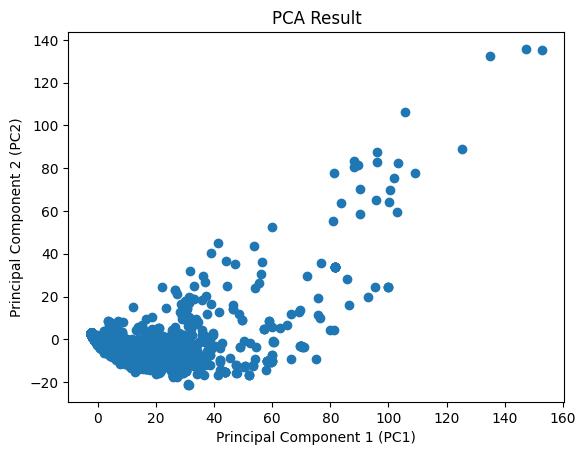

In [32]:
# Case 5 - PCA, taking no future info as baseline as it achieved max accuracy
data = df_no_future.copy()

scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)

pca = PCA(n_components=2)
principal_components = pca.fit_transform(scaled_data)

pc_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])

# Display the explained variance ratio
print("Explained Variance Ratio:")
print(pca.explained_variance_ratio_)

# Plot the results
plt.scatter(pc_df['PC1'], pc_df['PC2'])
plt.title('PCA Result')
plt.xlabel('Principal Component 1 (PC1)')
plt.ylabel('Principal Component 2 (PC2)')
plt.show()

In [33]:
# Case 6 - using chi-square for feature selection
data = df_no_future.copy()
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(X_train)

k_best = SelectKBest(score_func=chi2, k='all')
k_best.fit(scaled_data, y_train)

selected_features_indices = k_best.get_support(indices=True)

x_train_selected = k_best.transform(scaled_data)

accuracies_features.append(train_RF(x_train_selected, y_train))


Average F1 Score: 0.9104697680452611
Average Accuracy: 0.9217335971240482
Average Precision: 0.9172309768475302
Average Recall: 0.9038339492378042


In [34]:
# Perform ANOVA test to see if there is significant difference between the accuracies
f_statistic, p_value = f_oneway(*accuracies_features)

# Print the results
print(f'F-statistic: {f_statistic}')
print(f'P-value: {p_value}')

# Check if the p-value is below the significance level (e.g., 0.05)
if p_value < 0.05:
    print('The means of the accuracy vectors are significantly different.')
else:
    print('There is no significant difference in means between the accuracy vectors.')

F-statistic: 270.3659549991617
P-value: 1.9056022828871137e-23
The means of the accuracy vectors are significantly different.


In [35]:
# pairwise statistical difference of accuracies between different set of features

feature_selection_type = ['baseline', 'no google embeddings', 'no future information', 'No vpm_patent_score', 'no future info and vppm', 'PCA: 618 features', 'chi-square feature selection']


print('Statistical test for difference between baseline accuracies and reduced features accuracies')
print()

# Perform paired t-test for each pair of lists
num_lists = len(accuracies_features)

for i in range(num_lists - 1):
    for j in range(i + 1, num_lists):
        acc_list_1 = accuracies_features[i]
        acc_list_2 = accuracies_features[j]

        # Perform paired t-test
        t_statistic, p_value = ttest_rel(acc_list_1, acc_list_2)

        # Display the results
        # print(f"T-statistic for Pair {i+1}-{j+1}: {t_statistic}")
        print(f"P-value for {feature_selection_type[i]} and {feature_selection_type[j]}: {p_value}")

        # Check for statistical significance (common significance level is 0.05)
        if p_value < 0.05:
            print(f"The difference in accuracies between {feature_selection_type[i]} and {feature_selection_type[j]} is statistically significant.")
        else:
            print(f"There is no statistically significant difference in accuracies between Pair {feature_selection_type[i]} and {feature_selection_type[j]}.")

        print()
    

Statistical test for difference between baseline accuracies and reduced features accuracies

P-value for baseline and no google embeddings: 0.008015696383196595
The difference in accuracies between baseline and no google embeddings is statistically significant.

P-value for baseline and no future information: 0.7282614966698906
There is no statistically significant difference in accuracies between Pair baseline and no future information.

P-value for baseline and No vpm_patent_score: 4.076270341827097e-05
The difference in accuracies between baseline and No vpm_patent_score is statistically significant.

P-value for baseline and no future info and vppm: 3.6248810150422344e-06
The difference in accuracies between baseline and no future info and vppm is statistically significant.

P-value for baseline and PCA: 618 features: 4.445888390291907e-05
The difference in accuracies between baseline and PCA: 618 features is statistically significant.

P-value for baseline and chi-square feature s

In [36]:
for name, accuracy in zip(feature_selection_type, accuracies_features): 
    print(name, np.mean(accuracy))

baseline 0.9208243241513442
no google embeddings 0.9172339664507978
no future information 0.9210807969087165
No vpm_patent_score 0.8913316583563278
no future info and vppm 0.8909819590969301
PCA: 618 features 0.8753847709645551
chi-square feature selection 0.9217335971240482


In the following analysis we won't consider "chi-square feature selection" as that didn't drop any feature. <br>
Some differences between accuraccies are statistically, but not all of them. The interesting thing to notice is that the regularization that comes from dropping a certain subset of features doesn't lead to an improvement in performances.<br>
Removing google embedings and future information didn't lead to any statistical significant reduction in the accuracy which means that these information aren't of central importance for predicting commercialization

0.9234427452443118


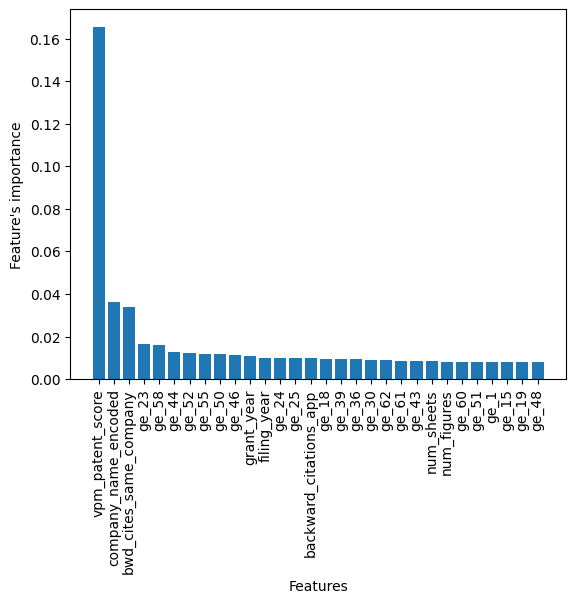

In [37]:
# plot 30 most important features when all features are taken into consideration

plot_features_importance(X_train, X_test, y_train, y_test, [])

0.8978925773964939


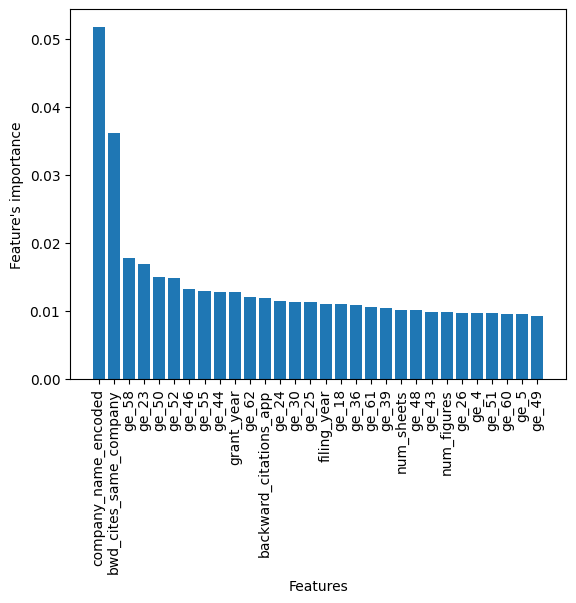

In [38]:
# plot 30 most important features when without VPM score

plot_features_importance(df_no_vpm, X_test, y_train, y_test, vpm_patent_score)

0.9188735546437896


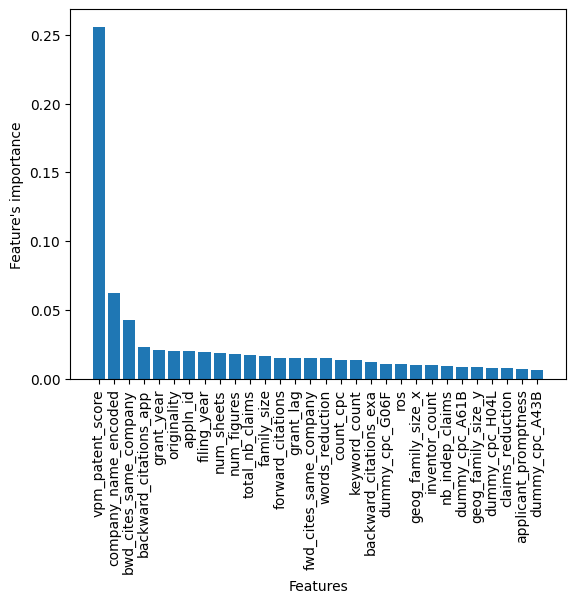

In [39]:
# plot 30 most important features when without google embedings
plot_features_importance(df_no_google, X_test, y_train, y_test, google_embeddings)

0.8956546064901156


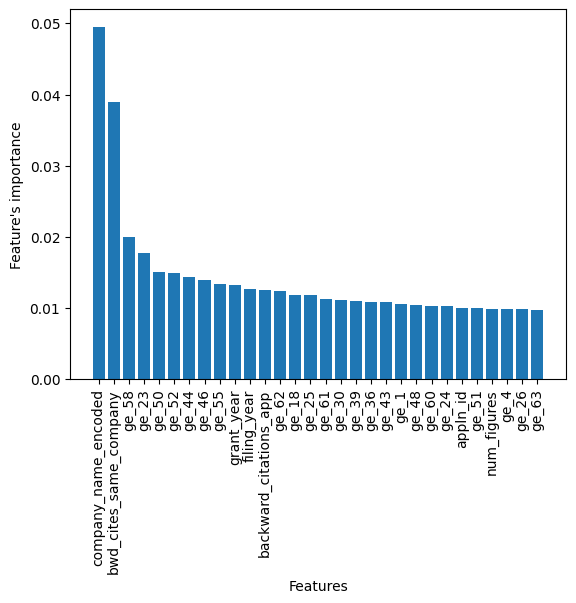

In [40]:
# withouth future information and VPM scores

plot_features_importance(df_no_future_vpm, X_test, y_train, y_test, future_info_vpm)

## BERT to encode abstracts

In [41]:
# Define your dataset class
class CustomDataset(Dataset):
    def __init__(self, features, texts, labels, tokenizer, max_length):
        self.features = features
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        text = list(self.texts.iloc[idx])
        label = int(self.labels[idx])

        # tokenize text of interest
        encoding = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_length, return_tensors='pt')
        
        return {
            'features': torch.tensor(self.features.iloc[idx]),
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }


class CustomBERTClassifier(torch.nn.Module):
    def __init__(self, num_classes, feature_dim):
        super(CustomBERTClassifier, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased', num_labels=num_classes)
        
        # Freeze all BERT layers except the last three
        for param in self.bert.parameters():
            param.requires_grad = False

        # unfreeze last encoder layer
        for param in self.bert.encoder.layer[-1:].parameters():
            param.requires_grad = True
            
        self.fc = torch.nn.Linear(feature_dim + self.bert.config.hidden_size, 128)  
        self.final_layer = torch.nn.Linear(128, num_classes)

    def forward(self, input_ids, attention_mask, features):
        outputs = self.bert(input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output

        # Concatenate BERT output with additional features
        combined_features = torch.cat([pooled_output, features], dim=1)

        # Fully connected layer
        combined_features = torch.relu(self.fc(combined_features))

        # Final classification layer
        logits = self.final_layer(combined_features)

        return logits

In [42]:
df_clean[['abstract', 'description_text']] = text  # incorporate text
df_clean.fillna(0, inplace=True)
X_train, X_test, y_train, y_test = train_test_split(df_clean, y, test_size=0.20, random_state=42)

In [43]:
# load model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device  = 'cpu'

# Set up your data and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
max_length = 128  # Adjust as needed
num_classes = 2  # Binary classification

# reset indexes, otherwise it doesn't work
X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)

features = X_train.drop(['abstract', 'description_text'], axis = 1)

# only using abstract as text description doesn't seem too useful and would slow down training
texts = X_train[['abstract']]   

scaler = StandardScaler()
features = pd.DataFrame(scaler.fit_transform(features))

# instanciate dataset and dataloader
dataset = CustomDataset(features, texts, y_train, tokenizer, max_length)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)
 
model = CustomBERTClassifier(num_classes, len(features.columns))
model.to(device)  # Move the model to GPU if available
 
print('loaded')

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

loaded


In [44]:
num_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
tot_params = sum(p.numel() for p in model.parameters())

print("Number of trainable parameters in the model:", num_trainable_params, f'out of {tot_params} total parameter')

Number of trainable parameters in the model: 7294594 out of 109688962 total parameter


In [47]:

if torch.cuda.is_available() == False: 
    model = torch.load('models/bert_trained.pth', map_location=torch.device('cpu'))

elif os.path.isfile('models/bert_trained.pth'): 
    model = torch.load('models/bert_trained.pth')
    model.to(device) 

else: 

    losses = []
    optimizer = AdamW(model.parameters(), lr=3e-5)

    num_epochs = 12 # Adjust as needed

    for epoch in range(num_epochs):
        # print('epoch:', epoch)
        model.train()

        # Iterate through batches in the data loader
        for num, batch in enumerate(dataloader):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            features = batch['features'].to(device)
            labels = batch['label'].to(device)

            optimizer.zero_grad()

            features = features.to(torch.float32)       

            # Forward pass through the model
            outputs = model(input_ids, attention_mask=attention_mask, features=features)

            # Compute the cross-entropy loss
            loss = torch.nn.functional.cross_entropy(outputs, labels)

            # Append the loss to the list for later analysis
            losses.append(loss.item())

            # Backward pass and optimization step
            loss.backward()
            optimizer.step()    

            # Explicitly release memory to prevent RAM overflow
            del input_ids, attention_mask, features, labels, outputs, loss

    plt.plot(pd.Series(losses).rolling(20, min_periods=1).sum())
    plt.xlabel('iterations')
    plt.ylabel('cross entropy loss')

In [48]:
# Expected execution time: 1 minutes
# Evaluation

# Reset index to ensure correct alignment
X_test.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

# Extract features and texts for testing
features_test = X_test.drop(['abstract', 'description_text'], axis = 1)
texts_test = X_test[['abstract']]

# Standardize numerical features
scaler = StandardScaler()
features_test = pd.DataFrame(scaler.fit_transform(features_test))

# Create a dataset and dataloader for testing
test_dataset = CustomDataset(features_test, texts_test, y_test, tokenizer, max_length)
dataloader_test = DataLoader(test_dataset, batch_size=32) # withour shuflling in order to have prediction in the right order

# Predictions
y_pred = []

with torch.no_grad():
    for num, batch in enumerate(dataloader_test): 
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        features = batch['features'].to(device)
        labels = batch['label'].to(device)

        features = features.to(torch.float32)   
        y_pred.append(model(input_ids, attention_mask =attention_mask, features=features))

        # Explicitly release memory to prevent RAM overflow
        del input_ids, attention_mask, features, labels


In [49]:
final_pred = []

for pred in y_pred: 
    final_pred.extend(pred.argmax(dim= 1).to('cpu').tolist())

In [50]:


# print('f1-score', f1_score(y_test, final_pred))
precision, recall, f_score, support = precision_recall_fscore_support(y_test, final_pred, average='macro')
print('accuracy', (final_pred == y_test).sum() / len(y_test))
print('precision', precision)
print('recall', recall)
print('f1', f_score)

accuracy 0.9038604998135025
precision 0.9026772030656401
recall 0.9026263646899115
f1 0.9026517107451546


In [51]:
# save model if it didn't exists
if not os.path.isfile('models/bert_trained.pth'): 
    torch.save(model, 'models/bert_trained.pth')

# BERT without google embedings

In [52]:
# load model
df_clean[['abstract', 'description_text']] = text  # incorporate text
df_clean.fillna(0, inplace=True)
df_no_google = modify_df(df_clean, google_embeddings)

X_train, X_test, y_train, y_test = train_test_split(df_no_google, y, test_size=0.20, random_state=42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device  = 'cpu'

# Set up your data and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
max_length = 128  # Adjust as needed
num_classes = 2  # Binary classification

# reset indexes, otherwise it doesn't work
X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)

features = X_train.drop(['abstract', 'description_text'], axis = 1)

# only using abstract as text description doesn't seem too useful and would slow down training
texts = X_train[['abstract']]   

scaler = StandardScaler()
features = pd.DataFrame(scaler.fit_transform(features))

# instanciate dataset and dataloader
dataset = CustomDataset(features, texts, y_train, tokenizer, max_length)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

print('loaded')


loaded


In [54]:
# training bert without google embedings

if torch.cuda.is_available() == False: 
    model = torch.load('models/bert_trained_no_ge.pth', map_location=torch.device('cpu'))

elif os.path.isfile('models/bert_trained_no_ge.pth'): 
    print('using saved parameters')
    model = torch.load('models/bert_trained_no_ge.pth')
    model.to(device) 

else: 
    print('training from scratch')
    losses = []
    optimizer = AdamW(model.parameters(), lr=3e-5)

    num_epochs = 12 # Adjust as needed

    for epoch in range(num_epochs):
        print('epoch:', epoch)
        model.train()

        # Iterate through batches in the data loader
        for num, batch in enumerate(dataloader):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            features = batch['features'].to(device)
            labels = batch['label'].to(device)

            optimizer.zero_grad()

            features = features.to(torch.float32)       

            # Forward pass through the model
            outputs = model(input_ids, attention_mask=attention_mask, features=features)

            # Compute the cross-entropy loss
            loss = torch.nn.functional.cross_entropy(outputs, labels)

            # Append the loss to the list for later analysis
            losses.append(loss.item())

            # Backward pass and optimization step
            loss.backward()
            optimizer.step()    

            # Explicitly release memory to prevent RAM overflow
            del input_ids, attention_mask, features, labels, outputs, loss

    plt.plot(pd.Series(losses).rolling(20, min_periods=1).sum())
    plt.xlabel('iterations')
    plt.ylabel('cross entropy loss')

In [55]:
# Expected execution time: 2 minutes
# Evaluation

# Reset index to ensure correct alignment
X_test.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)


# Extract features and texts for testing
features_test = X_test.drop(['abstract', 'description_text'], axis = 1)
texts_test = X_test[['abstract']]

# Standardize numerical features
scaler = StandardScaler()
features_test = pd.DataFrame(scaler.fit_transform(features_test))

# Create a dataset and dataloader for testing
test_dataset = CustomDataset(features_test, texts_test, y_test, tokenizer, max_length)
dataloader_test = DataLoader(test_dataset, batch_size=32) # withour shuflling in order to have prediction in the right order

# Predictions
y_pred = []

with torch.no_grad():
    for num, batch in enumerate(dataloader_test): 
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        features = batch['features'].to(device)
        labels = batch['label'].to(device)

        features = features.to(torch.float32)   
        y_pred.append(model(input_ids, attention_mask =attention_mask, features=features))

        # Explicitly release memory to prevent RAM overflow
        del input_ids, attention_mask, features, labels


In [56]:
final_pred = []

for pred in y_pred: 
    final_pred.extend(pred.argmax(dim= 1).to('cpu').tolist())

# print('f1-score', f1_score(y_test, final_pred))
precision, recall, f_score, support = precision_recall_fscore_support(y_test, final_pred, average='macro')
print('accuracy', (final_pred == y_test).sum() / len(y_test))
print('precision', precision)
print('recall', recall)
print('f1', f_score)

accuracy 0.9056322267810518
precision 0.9037562112759829
recall 0.9062987703686612
f1 0.9047775276576897


In [57]:
# save model if it didn't exists
if not os.path.isfile('models/bert_trained_no_ge.pth'): 
    torch.save(model, 'models/bert_trained_no_ge.pth')